In [48]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import happybase
import collections
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [49]:
print(tf.__version__)
print(tf.config.list_physical_devices())

2.9.2
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [50]:
pre_days = 2
mem_his_days = 10
num_feature = 17
epoch = 500
train_rate = 0.99
batch_size = 128
table_name = 'certificate'
column_family = 'feature'
stock_code = '002316'

In [51]:
def change2label(x):
    if x < 0.92:
       return 0
    elif x < 0.94:
       return 1
    elif x < 0.96:
       return 2
    elif x < 0.98:
       return 3
    elif x < 1.:
       return 4
    elif x < 1.2:
       return 5
    elif x < 1.4:
       return 6
    elif x < 1.6:
       return 7
    elif x < 1.8:
       return 8
    return 9

def label2change(label):
    if label == 0:
        return 0.91
    elif label == 1:
        return 0.93
    elif label == 2:
        return 0.95
    elif label == 3:
        return 0.97
    elif label == 4:
        return 0.99
    elif label == 5:
        return 1.1
    elif label == 6:
        return 1.3
    elif label == 7:
        return 1.5
    elif label == 8:
        return 1.7
    return 1.9

In [52]:
# load features from hbase
connection = happybase.Connection('localhost', 9090, transport='framed', protocol='compact')
connection.open()
table = connection.table(table_name)
rows = table.scan(row_prefix=stock_code.encode('utf-8'))
df = pd.DataFrame()
idx = int(0)
newest_data = '1970-01-01'
for row in rows:
    date = row[0].decode('utf-8').split('_')[-1]
    cells = row[1]
    for column in cells:
        df.at[idx, column.decode('utf-8').split(':')[-1]] = np.float32(cells[column].decode('utf-8'))
    df.at[idx, 'date'] = date
    newest_data = max(date, newest_data)
    
    idx = idx + 1
connection.close()
df.dropna(inplace=True)
df

,macd_dea,macd_diff,macd_ema12,macd_ema26,macd_macd,trade_c,trade_e,trade_h,trade_hs,trade_l,trade_o,trade_v,trade_zd,trade_zde,trade_zf,date,kdj_d,kdj_j,kdj_k
8,-0.130,-0.836,34.603001,35.439400,-1.412,31.18,90117944.0,31.690001,12.060000,30.400000,30.469999,28941.0,1.53,0.47,4.20,2009-12-21,8.500000,8.500000,8.500000
9,-0.352,-1.241,33.704102,34.944599,-1.776,28.76,114190072.0,31.080000,16.139999,28.600000,30.889999,38735.0,-7.76,-2.42,7.95,2009-12-22,7.680000,2.790000,6.050000
10,-0.561,-1.397,33.224998,34.622002,-1.672,30.59,155427968.0,31.290001,21.440001,28.690001,28.690001,51455.0,6.36,1.83,9.04,2009-12-23,8.030000,10.130000,8.730000
11,-0.737,-1.439,32.944199,34.383301,-1.405,31.40,152094352.0,31.799999,20.629999,29.389999,30.170000,49503.0,2.65,0.81,7.88,2009-12-24,9.880000,20.980000,13.580000
12,-0.891,-1.508,32.605099,34.113400,-1.234,30.74,90032200.0,31.389999,12.130000,30.420000,30.500000,29106.0,-2.10,-0.66,3.09,2009-12-25,12.130000,25.660000,16.639999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2852,0.113,0.165,5.015800,4.851300,0.104,5.54,212349872.0,5.540000,12.510000,5.010000,5.010000,394061.0,9.92,0.50,10.52,2023-07-14,65.970001,74.309998,68.750000
2853,0.129,0.196,5.099500,4.903800,0.133,5.56,599063808.0,5.940000,33.700001,5.400000,5.540000,1061622.0,0.36,0.02,9.75,2023-07-17,66.760002,71.500000,68.339996
2854,0.143,0.200,5.135000,4.935400,0.113,5.33,313424032.0,5.480000,18.760000,5.200000,5.410000,591018.0,-4.14,-0.23,5.04,2023-07-18,65.019997,54.520000,61.520000
2855,0.163,0.243,5.246500,5.003900,0.159,5.86,271282048.0,5.860000,14.860000,5.230000,5.250000,468242.0,9.94,0.53,11.82,2023-07-19,67.360001,81.459999,72.059998


In [53]:
df['PreHigh'] = df['trade_h'].shift(1)
df["Change"] = df['trade_h'] / df['PreHigh']

df = df.dropna()
change = np.array(df['Change']).astype(np.float32)
df['Change'] = df['Change'].apply(change2label)

df = df.drop('trade_h', axis=1)
df = df.drop('PreHigh', axis=1)

date = df['date']
df = df.drop(labels='date', axis=1)

scaler = MinMaxScaler((0, 1))

sca = scaler.fit_transform(df.iloc[:, :-1])
print(scaler.data_max_, scaler.data_min_)
label = np.array(df.iloc[:, -1])
print(sca)
print(label)
print(change)

[2.06299996e+00 2.34999990e+00 3.37041016e+01 3.49445992e+01
 1.86300004e+00 3.50800018e+01 1.73344512e+09 5.65800018e+01
 3.36300011e+01 3.50000000e+01 1.66022800e+06 1.01199999e+01
 2.24000001e+00 1.99500008e+01 9.65899963e+01 1.24339996e+02
 9.90800018e+01] [-2.39299989e+00 -2.64299989e+00  2.29970002e+00  2.41529989e+00
 -1.77600002e+00  2.24000001e+00  4.41216000e+05  5.00000007e-02
  2.21000004e+00  2.22000003e+00  1.53200000e+03 -3.29399986e+01
 -6.32000017e+00  0.00000000e+00  4.46000004e+00 -2.51299992e+01
  1.70000005e+00]
[[0.4580341  0.28079309 1.         ... 0.03495061 0.18679334 0.04467036]
 [0.41113105 0.24954937 0.98474408 ... 0.03874959 0.23590018 0.07219141]
 [0.37163374 0.24113758 0.97580266 ... 0.05882992 0.30849    0.1219963 ]
 ...
 [0.56912028 0.56939716 0.09028353 ... 0.65733202 0.53288287 0.61429451]
 [0.57360861 0.57800921 0.09383398 ... 0.68273096 0.7131197  0.72253025]
 [0.58078994 0.59363109 0.09973125 ... 0.73331162 0.8374256  0.81803244]]
[4 5 5 ... 1 5 5]

/var/folders/b1/0fd1b6hs7lz0fm_mh346lybm0000gn/T/ipykernel_75084/3599398066.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Change'] = df['Change'].apply(change2label)


In [54]:
deq = collections.deque()

x = list()
for row in sca:
    deq.append(list(row))
    if len(deq) > mem_his_days:
        deq.popleft()
    if len(deq) == mem_his_days:
        x.append(np.array(deq).reshape(-1, 1))
predict_x = x[-pre_days:]
x = x[:-pre_days]
y = label[mem_his_days + pre_days - 1:]
change = change[mem_his_days + pre_days - 1:]

x, y = np.array(x).reshape(-1, num_feature * mem_his_days, 1), np.array(y)
print(x.shape)
print(y.shape)

(2837, 170, 1)
(2837,)


In [55]:
total_num = len(x)
train_num = int(total_num * train_rate)
print(train_num)

2808


In [56]:
x_train, y_train, change_train = x[:train_num], y[:train_num], change[:train_num]
x_test, y_test, change_test = x[train_num:], y[train_num:], change[train_num:]

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(train_num).batch(batch_size=batch_size).prefetch(tf.data.experimental.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = test_ds.shuffle(total_num - train_num).batch(batch_size=batch_size).prefetch(tf.data.experimental.AUTOTUNE)

sample = next(iter(train_ds))
print('x_train.shape:', sample[0].shape)
print('y_train.shape:', sample[1].shape)
print(change_test)

x_train.shape: (128, 170, 1)
y_train.shape: (128,)
[0.9912854  1.0021977  0.99561405 1.0726871  0.99589324 0.97938144
 0.9978947  1.0126584  0.9874999  0.98312235 0.95708156 1.0403587
 1.0625     0.9776877  1.0311203  1.         0.98792756 1.0285133
 1.0118812  0.98043054 0.9900199  1.0705645  1.0338982  0.9489982
 1.0633397  1.0722022  0.9225589  1.0693431  1.1006825 ]


In [57]:
input_shape = sample[0].shape[-2:]
print(input_shape)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv1D(32,num_feature * mem_his_days,input_shape=input_shape,padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.MaxPooling1D())
model.add(tf.keras.layers.Conv1D(64,num_feature * mem_his_days,padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.MaxPooling1D())
model.add(tf.keras.layers.Conv1D(64,num_feature * mem_his_days,padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.GlobalAveragePooling1D())
model.add(tf.keras.layers.Dense(64))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.Dense(10,activation='softmax'))
model.build(input_shape=[None, num_feature * mem_his_days])

model.summary()

(170, 1)
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 170, 32)           5472      
                                                                 
 batch_normalization_32 (Bat  (None, 170, 32)          128       
 chNormalization)                                                
                                                                 
 re_lu_32 (ReLU)             (None, 170, 32)           0         
                                                                 
 dropout_24 (Dropout)        (None, 170, 32)           0         
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 85, 32)           0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 85, 64) 

In [58]:
# lr = tf.keras.optimizers.schedules.ExponentialDecay(0.01, decay_steps=20, decay_rate=0.8, staircase=False)
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy()
metrics = tf.keras.metrics.SparseCategoricalAccuracy()

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=[metrics])

# model.compile(optimizer=tf.keras.optimizers.RMSprop(),
#               loss=tf.keras.losses.MeanAbsoluteError(),
#               metrics=tf.keras.losses.MeanSquaredLogarithmicError())

def lr_schedule(epoch):
    if epoch > 350:
        return 0.0001
    if epoch > 200:
        return 0.0005
    if epoch > 150:
        return 0.001
    if epoch > 100:
        return 0.002
    if epoch > 50:
        return 0.005
    return 0.01
        
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule,verbose=True)

history = model.fit(train_ds,
                    epochs=epoch,
                    validation_data=test_ds,
                    callbacks=[lr_callback])


Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/500


2023-07-21 13:17:05.300678: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - ETA: 0s - loss: 1.4980 - sparse_categorical_accuracy: 0.4088

2023-07-21 13:17:08.202389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 4s 98ms/step - loss: 1.4980 - sparse_categorical_accuracy: 0.4088 - val_loss: 19.6669 - val_sparse_categorical_accuracy: 0.2414 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.01.
Epoch 2/500
22/22 [==============================] - 1s 35ms/step - loss: 1.2585 - sparse_categorical_accuracy: 0.4644 - val_loss: 2.0809 - val_sparse_categorical_accuracy: 0.0690 - lr: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.01.
Epoch 3/500
22/22 [==============================] - 1s 34ms/step - loss: 1.2472 - sparse_categorical_accuracy: 0.4676 - val_loss: 1.5283 - val_sparse_categorical_accuracy: 0.5172 - lr: 0.0100

Epoch 4: LearningRateScheduler setting learning rate to 0.01.
Epoch 4/500
22/22 [==============================] - 1s 36ms/step - loss: 1.2463 - sparse_categorical_accuracy: 0.4615 - val_loss: 1.7198 - val_sparse_categorical_accuracy: 0.3103 - lr: 0.0100

Epoch 5: LearningRateScheduler setting learning r

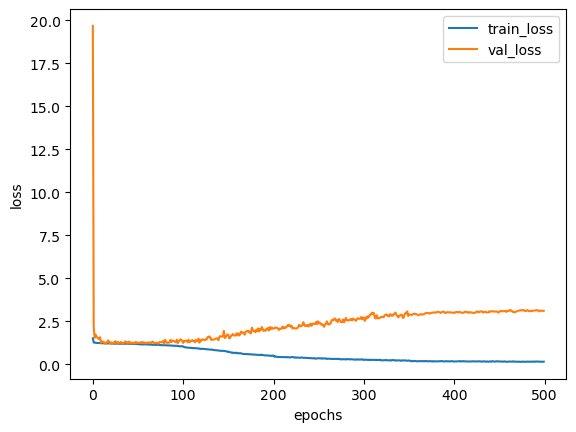

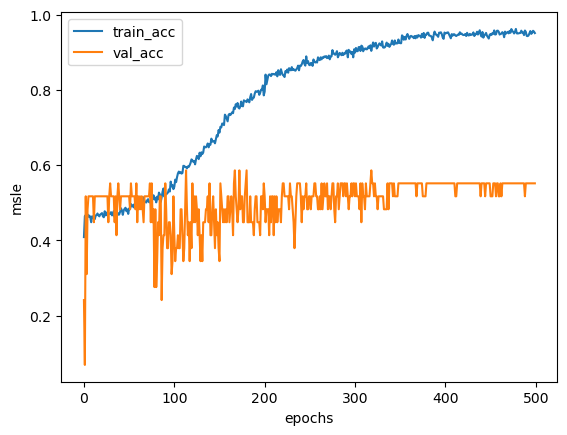

In [59]:
train_acc = history.history['sparse_categorical_accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_sparse_categorical_accuracy']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(range(epoch), train_loss, label='train_loss')
plt.plot(range(epoch), val_loss, label='val_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

plt.figure()
plt.plot(range(epoch), train_acc, label='train_acc')
plt.plot(range(epoch), val_acc, label='val_acc')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('msle')
plt.show()

1/1 [==============================] - 0s 183ms/step


2023-07-21 13:23:35.910517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[4 5 5 5 5 3 4 4 4 4 3 4 5 4 4 4 4 5 5 5 2 5 5 4 5 5 4 4 5]


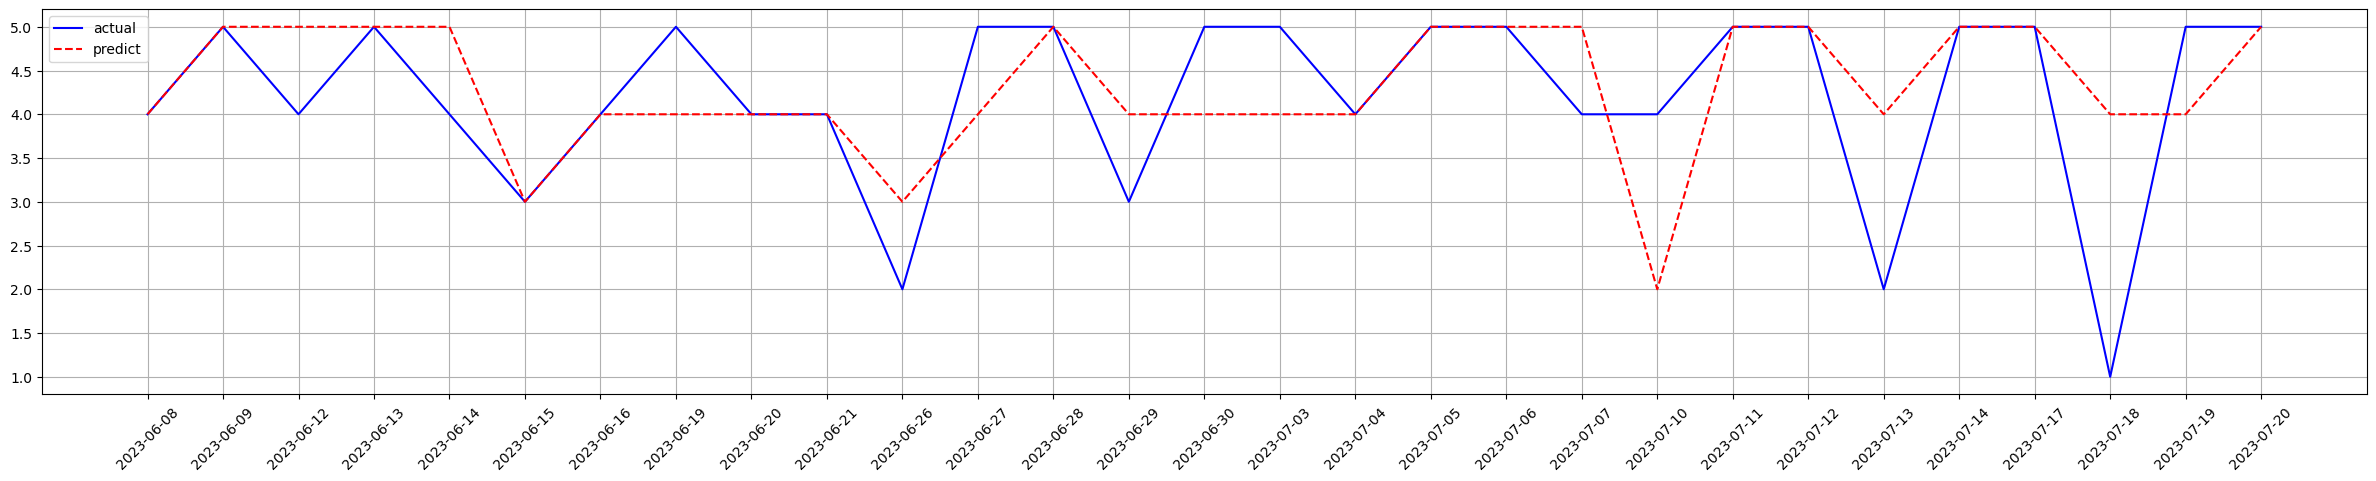

In [60]:
model.evaluate(test_ds)

y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

df_time = date[-len(y_test):]

fig = plt.figure(figsize=(30, 5))
axes = fig.add_subplot(111)
axes.plot(df_time, y_test, 'b-', label='actual')
axes.plot(df_time, y_pred, 'r--', label='predict')
print(y_pred)
axes.set_xticks(df_time[::1])
axes.set_xticklabels(df_time[::1],rotation=45)

plt.legend()
plt.grid()
plt.show()

In [61]:
price_actual = list()
price_pred = list()
price_actual.append(1.0)
price_pred.append(1.0)
    

for idx in range(1, len(y_test)):
    price_actual.append(price_actual[idx-1] * change_test[idx])
    price_pred.append(price_pred[idx-1] * label2change(y_pred[idx]))
print(price_actual)
print(price_pred)

[1.0, 1.0021977424621582, 0.9978021550964513, 1.0703295490642146, 1.0659339624585153, 1.0439559413040178, 1.0417581053935308, 1.054945052045385, 1.0417581257114925, 1.024175695415759, 0.980219668513828, 1.0197800233944425, 1.0835162748565952, 1.0593405525378703, 1.0923075486453682, 1.0923075486453682, 1.0791207269749712, 1.109890033315542, 1.1230768945862628, 1.1010988900646868, 1.0901098322880776, 1.1670328967470367, 1.2065932513953992, 1.1450548391680666, 1.2175822808848387, 1.3054944071347725, 1.2043954890251036, 1.2879119938852652, 1.417582189377483]
[1.0, 1.1, 1.2100000000000002, 1.3310000000000004, 1.4641000000000006, 1.4201770000000005, 1.4059752300000004, 1.3919154777000002, 1.3779963229230001, 1.3642163596937702, 1.323289868902957, 1.3100569702139275, 1.4410626672353204, 1.4266520405629672, 1.4123855201573376, 1.3982616649557642, 1.3842790483062066, 1.5227069531368274, 1.6749776484505103, 1.8424754132955614, 1.7503516426307832, 1.9253868068938618, 2.117925487583248, 2.09674623

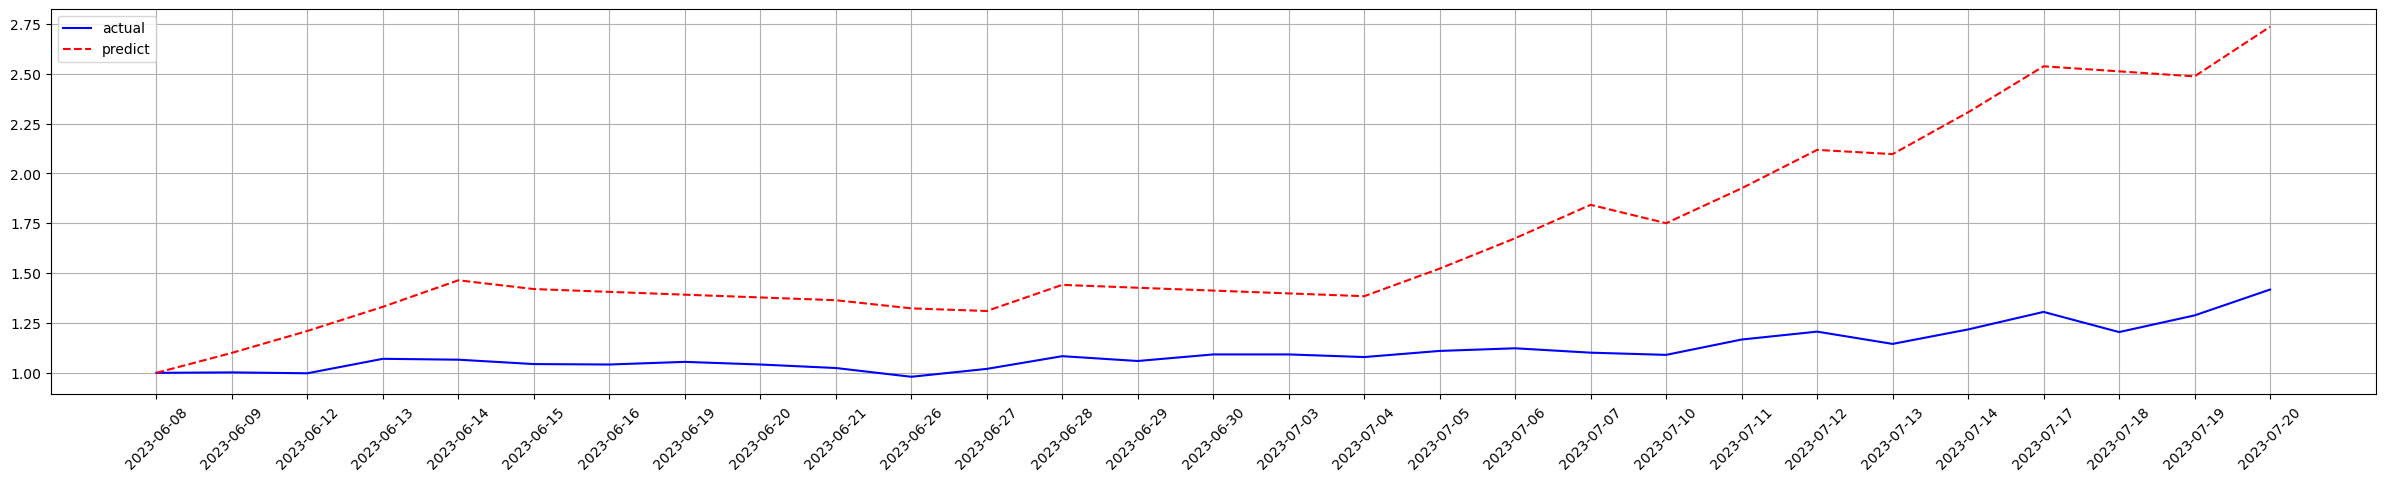

In [62]:
df_time = date[-len(y_test):]

fig = plt.figure(figsize=(30, 5))
axes = fig.add_subplot(111)
axes.plot(df_time, price_actual, 'b-', label='actual')
axes.plot(df_time, price_pred, 'r--', label='predict')

axes.set_xticks(df_time[::1])
axes.set_xticklabels(df_time[::1],rotation=45)

plt.legend()
plt.grid()
plt.show()

In [63]:
actual_profit_rate = 1
for idx in range(0, len(y_pred)):
    if y_pred[idx] >= 1:
        actual_profit_rate *= change_test[idx]
print(actual_profit_rate)

1.4052285045252226


88/88 [==============================] - 1s 10ms/step
(2808,)


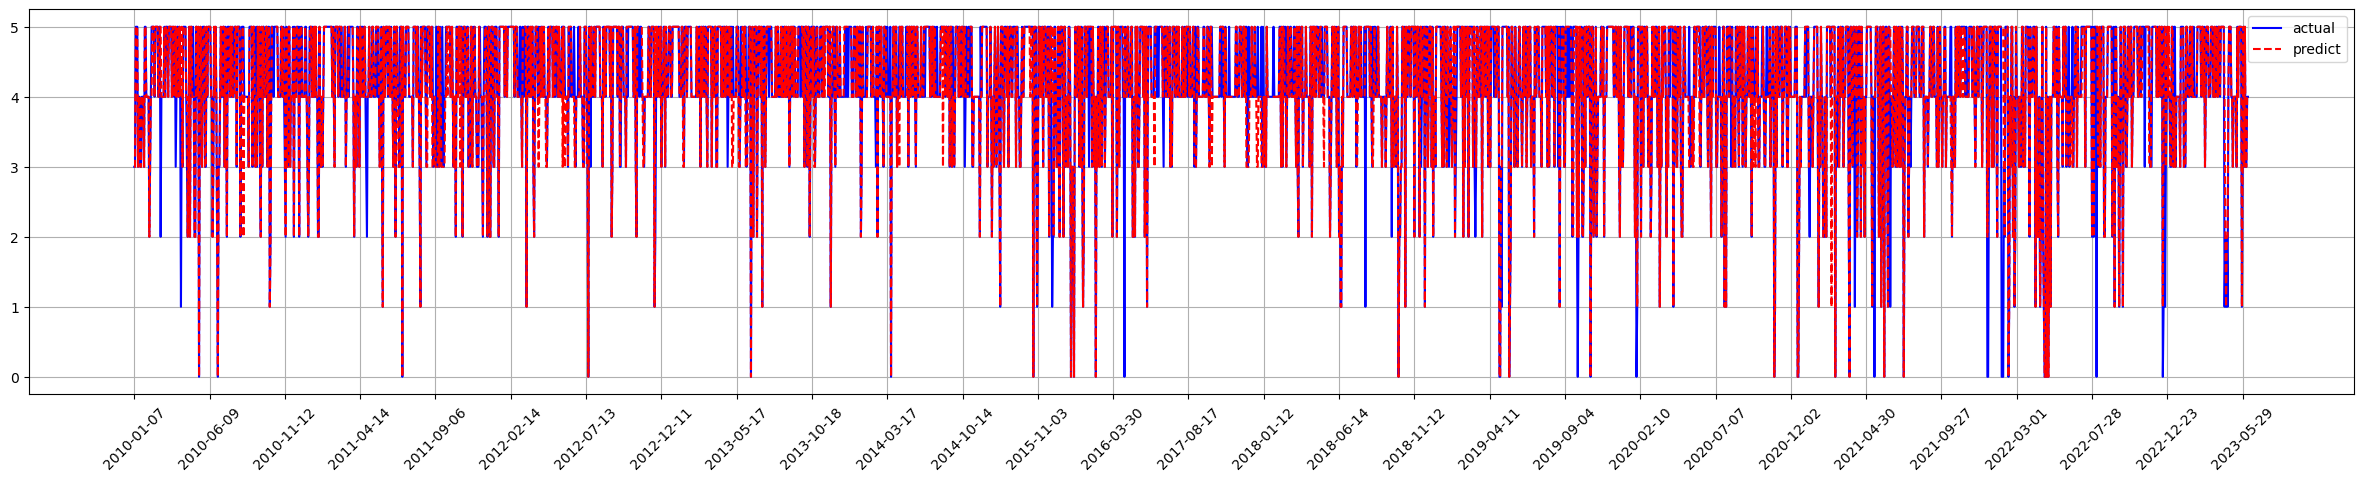

In [64]:
predict_train = model.predict(x_train)
predict_train = np.argmax(predict_train, axis=1)

df_time = date[mem_his_days + pre_days - 1 :mem_his_days + pre_days - 1 + len(predict_train)]

fig = plt.figure(figsize=(30, 5))
axes = fig.add_subplot(111)
axes.plot(df_time, y_train, 'b-', label='actual')
print(predict_train.shape)
axes.plot(df_time, predict_train, 'r--', label='predict')

axes.set_xticks(df_time[::100])
axes.set_xticklabels(df_time[::100],rotation=45)

plt.legend()
plt.grid()
plt.show()

In [66]:
predict_x = np.array(predict_x).reshape(-1,num_feature * mem_his_days,1)
predict = model.predict(predict_x)
predict = np.argmax(predict, axis=1)

def up_or_down(pred):
    if pred >= 3:
        return '↗'
    return '↘'
print('Current code is ' + stock_code + ', current date is ' + newest_data)
print('T+1 ' + up_or_down(predict[0]))
print('T+2 ' + up_or_down(predict[1]))

1/1 [==============================] - 0s 153ms/step
Current code is 002316, current date is 2023-07-20
T+1 ↗
T+2 ↗
